# Chart Events for last 48 period

TODO:

1. [ ] Create or find list of `ITEMID`s that correlate to the 17 dimmensions from paper.
2. [ ] Extract the 17 dims from `CHARTEVENTS.csv` for each sample

|	Chart Event	|	Dim	|	Normal	|
| --- | :--- | :--- |
|	1. Glasgow coma scale eye opening	|	4	|	4 Spontaneously	|
|	2. Glasgow coma scale verbal response	|	5	|	5 Oriented	|
|	3. Glasgow coma scale motor response	|	6	|	6 Obeys Commands	|
|	4. Glasgow coma scale total	|	13	|	15	|
|	5. Capillary refill rate	|	2	|	Normal < 3 secs	|
|	6. Diastolic blood pressure	|	1	|	70	|
|	7. Systolic blood pressure	|	1	|	105	|
|	8. Mean blood pressure	|	1	|	87.5	|
|	9. Heart Rate	|	1	|	80	|
|	10. Glucose	|	1	|	85	|
|	11. Fraction inspired oxygen	|	1	|	0.21	|
|	12. Oxygen saturation	|	1	|	97.5	|
|	13. Respiratory rate	|	1	|	15	|
|	14. Body Temperature	|	1	|	37	|
|	15. pH	|	1	|	7.4	|
|	16. Weight	|	1	|	80.7	|
|	17. Height	|	1	|	168.8	|

![Glascow](assets/images/GCS.jpg)

https://www.firstaidforfree.com/glasgow-coma-scale-gcs-first-aiders/

In [1]:
event_to_id =[
{'CHAREVENT':'GCS_EYE', 'DESCRIPTION':'','ITEMID':['184','220739'],'UNIT':['NONE','NONE']},
{'CHAREVENT':'GCS_MOTOR', 'DESCRIPTION':'','ITEMID':['454','223901'],'UNIT':['NONE','NONE']},
{'CHAREVENT':'GCS_VERBAL', 'DESCRIPTION':'','ITEMID':['723','223900'],'UNIT':['NONE','NONE']},
{'CHAREVENT':'GCS_TOTAL', 'DESCRIPTION':'Sum of the 3 GCS events','ITEMID':['198'],'UNIT':['NONE']},
{'CHAREVENT':'CAPILLARY_REFILL', 'DESCRIPTION':'','ITEMID':['3348','115','8377','223951','224308'],'UNIT':['BINARY','BINARY','BINARY','BINARY','BINARY']},
{'CHAREVENT':'D_BLOOD_PRESSURE', 'DESCRIPTION':'','ITEMID':['8368','220051','225310','8555','8441','220180','8502','8440','8503','8504','8507','8506','224643','227242'],'UNIT':['mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg']},
{'CHAREVENT':'M_BLOOD_PRESSURE', 'DESCRIPTION':'','ITEMID':['52', '220052', '225312', '224', '6702', '224322', '456', '220181', '3312', '3314', '3316', '3322', '3320'],'UNIT':['mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg']},
{'CHAREVENT':'S_BLOOD_PRESSURE', 'DESCRIPTION':'','ITEMID':['51','220050','225309','6701','455','220179','3313','3315','442','3317','3323','3321','224167','227243'],'UNIT':['mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg','mmHg']},
{'CHAREVENT':'HEART_RATE', 'DESCRIPTION':'','ITEMID':['211','220045'],'UNIT':['bpm','bpm']},
{'CHAREVENT':'GLUCOSE', 'DESCRIPTION':'','ITEMID':['807', '811', '1529', '3745', '225664', '220621', '226537', '3447', '3816', '3744', '227015', '227016', '1310', '1455', '2338', '1812', '228388'],'UNIT':['','']},
{'CHAREVENT':'FRAC_OXYGEN', 'DESCRIPTION':'','ITEMID':['3420', '223835', '3422', '189', '727'],'UNIT':['%','%','%','%','%']},
{'CHAREVENT':'O2_SAT', 'DESCRIPTION':'','ITEMID':['834', '8498', '220227', '646', '220277'],'UNIT':['%','%','%','%','%']},
{'CHAREVENT':'RESP_RATE', 'DESCRIPTION':'','ITEMID':['618', '220210', '3603', '224689', '614', '651', '224422', '615', '224690', '619', '224688'],'UNIT':['insp/min','']},
{'CHAREVENT':'BODY_TEMP', 'DESCRIPTION':'','ITEMID':['3655','677','676','223762','3654','678','223761','679','8537','645','591','226329','597','227054','228242'],'UNIT':['C','C','C','C','F','F','F','F','C','','','','C','','F']},
{'CHAREVENT':'PH', 'DESCRIPTION':'','ITEMID':['3839','1673','780','1126','223830','4753','4202','860','220274','8387','1880','3777','227586','8385','1352','4755','7966'],'UNIT':['NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE','NONE']},
{'CHAREVENT':'WEIGHT', 'DESCRIPTION':'','ITEMID':['763','224639','226512','3580','3693','3581','226531','3582'],'UNIT':['?','kg','kg','kg','kg','lb','lb','oz']},
{'CHAREVENT':'HEIGHT', 'DESCRIPTION':'','ITEMID':['226707', '226730', '1394'],'UNIT':['?','cm','in']},
]

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import traceback
import os
import dask.dataframe as dd

In [3]:
CHARTEVENTS_FILENAME = 'mimic-iii/CHARTEVENTS.csv'
READMISSION_FILENAME = 'data/readmission.csv'
SAMPLES_DIR = 'data/samples/'
DATASTORE_FILENAME = 'samples.h5'
FEATHER_EXT = '.feather'
ROWS_TO_READ = 1000000
MAX_ROWS_CHARTEVENTS = 330712483

skip_rows = 0

In [4]:
chartevents_columns = ["ROW_ID","SUBJECT_ID","HADM_ID","ICUSTAY_ID","ITEMID","CHARTTIME","STORETIME","CGID","VALUE","VALUENUM","VALUEUOM","WARNING","ERROR","RESULTSTATUS","STOPPED"]



# chartevents_dtype = {'ROW_ID':object,
# 'SUBJECT_ID':np.int64,
# 'HADM_ID':np.int64,
# 'ICUSTAY_ID':np.int64,
# 'ITEMID':np.int64,
# 'CHARTTIME':object,
# 'STORETIME':object,
# 'CGID':np.int64,
# 'VALUE':object,
# 'VALUENUM':np.int64,
# 'VALUEUOM':object,
# 'WARNING':np.int64,
# 'ERROR':np.int64,
# 'RESULTSTATUS':object,
# 'STOPPED':object}

chartevents_dtype = {'ROW_ID':object,
'SUBJECT_ID':object,
'HADM_ID':object,
'ICUSTAY_ID':object,
'ITEMID':object,
'CHARTTIME':object,
'STORETIME':object,
'CGID':object,
'VALUE':object,
'VALUENUM':object,
'VALUEUOM':object,
'WARNING':object,
'ERROR':object,
'RESULTSTATUS':object,
'STOPPED':object}

In [5]:
readmission = pd.read_csv(READMISSION_FILENAME).sort_values(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).reset_index(drop=True)

# d = readmission.dtypes.to_dict()
# d

In [6]:
print(readmission.shape)
readmission.nunique()

(48882, 34)


Unnamed: 0              48882
SUBJECT_ID              35431
HADM_ID                 45731
ICUSTAY_ID              48882
ADMITTIME               45470
DISCHTIME               45519
DEATHTIME                1778
INTIME                  48881
OUTTIME                 48876
DOB                     25710
DOD                     10717
EXPIRE_FLAG                 2
HOSPITAL_EXPIRE_FLAG        2
HAS_CHARTEVENTS_DATA        2
FIRST_CAREUNIT              5
LAST_CAREUNIT               5
FIRST_WARDID               14
LAST_WARDID                14
LOS                     32231
INSURANCE                   5
LANGUAGE                   74
RELIGION                   20
MARITAL_STATUS              7
ETHNICITY                  41
DIAGNOSIS               14183
GENDER                      2
ICU_VISIT_PER_ADMIT         7
TRANSFERRED_RETURNED        2
TRANSFERRED_DEATH           2
DISCHARGED_RETURNED         2
DISCHARGED_DEATH            2
AGE                        84
DIED_IN_ICU                 1
READMISSIO

In [7]:
icustay_id = list(readmission['ICUSTAY_ID'].values)
icustay_id.insert(0,0)
icustay_id.sort()
print(icustay_id[:5])

[0, 200001, 200003, 200006, 200007]


In [8]:

#chartevents = dd.read_csv(CHARTEVENTS_FILENAME,names=chartevents_columns,dtype=chartevents_dtype)
chartevents = dd.read_csv(CHARTEVENTS_FILENAME,dtype=chartevents_dtype)
chartevents = chartevents.dropna(subset=['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CHARTTIME']).drop('ROW_ID',axis=1)
#print(chartevents.head())
try:
    chartevents['SUBJECT_ID'] = chartevents['SUBJECT_ID'].astype(np.int64)
    chartevents['HADM_ID'] = chartevents['HADM_ID'].astype(np.int64)
    chartevents['ICUSTAY_ID'] = chartevents['ICUSTAY_ID'].astype(np.int64)
    chartevents['CHARTTIME'] = dd.to_datetime(chartevents['CHARTTIME'], errors='coerce')
    #print(chartevents.dtypes)
except Exception as e:
    #print('\nError converting IDs to int in range', lines, 'to', lines + ROWS_TO_READ)
    print(str(e))



In [9]:
# valid_chartevents = dd.multi.merge(readmission[['SUBJECT_ID','HADM_ID','ICUSTAY_ID']],chartevents,'inner',['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).set_index('ICUSTAY_ID',sorted=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.199752 to fit


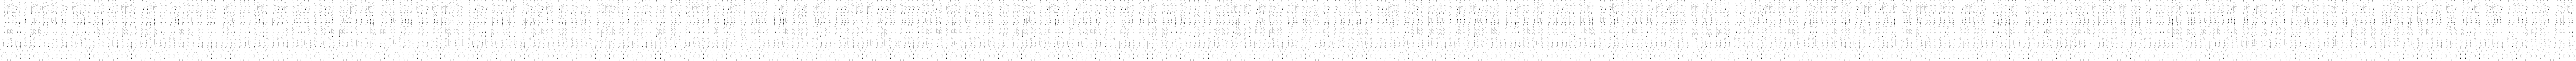

In [12]:
# ce = chartevents.persist()
chartevents.visualize()

In [ ]:
for row in readmission.itertuples():
    #print(row.HAS_CHARTEVENTS_DATA)
    #print(chartevents['SUBJECT_ID'] == row.SUBJECT_ID)
    #print(np.sum(chartevents['SUBJECT_ID'] == row.SUBJECT_ID).compute())
    df = chartevents[(chartevents['SUBJECT_ID'] == row.SUBJECT_ID) & (chartevents['HADM_ID'] == row.HADM_ID) & (chartevents['ICUSTAY_ID'] == row.ICUSTAY_ID)]
    
    dd.to_parquet(df,SAMPLES_DIR,append=True)
    break

In [ ]:



#print(chartevents.shape)
#chartevents = chartevents.sort_values(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).reset_index(drop=True)


#print(valid_chartevents.npartitions)

# max_chartevents_charttime = valid_chartevents.map_partitions(lambda df: df.groupby('ICUSTAY_ID')['CHARTTIME'].max().reset_index(name='MAX_CHARTTIME'))
# max_chartevents_charttime = max_chartevents_charttime.map_partitions(lambda df : df.sort_values(['ICUSTAY_ID']).reset_index(drop=True))







#valid_chartevents['MAX_CHARTTIME'] = valid_chartevents['CHARTTIME'].max()
#print(valid_chartevents.get_partition(1).head(1))

#valid_chartevents = valid_chartevents.groupby(['ICUSTAY_ID'],sort=False,split_out=valid_chartevents.npartitions)



#valid_chartevents = valid_chartevents.sort_values(['ICUSTAY_ID']).reset_index(drop=True)

# valid_chartevents = valid_chartevents.repartition(divisions=icustay_id)
# print(valid_chartevents.npartitions)






#print(valid_chartevents.shape)
#valid_chartevents = valid_chartevents.sort_values(['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CHARTTIME']).reset_index(drop=True)
#print(valid_chartevents.divisions)

# valid_chartevents = valid_chartevents.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])


# print(len(valid_chartevents.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])['SUBJECT_ID','HADM_ID','ICUSTAY_ID'].unique().compute()))

# v = valid_chartevents.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])
# print(v['ICUSTAY_ID'].unique().compute())
# for name, group in v:
#     group.to_parquet(SAMPLES_DIR)  
    # print(name)
    # print(group.head(1),end='\n\n')
    # group = group.sort_values(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).reset_index(drop=True)

    # name = str(name).strip('() ').replace(' ','').split(',')
    # filename = 'sample_' + '_'.join(name) + FEATHER_EXT
    

    # try:
    #     group.to_feather(SAMPLES_DIR + filename)
    # except Exception as e:
    #     pass
    
    
  

In [ ]:
print(valid_chartevents.get_partition(1).head(100))

    SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID           CHARTTIME   
0         7095   191813      294833  220180 2201-07-17 10:00:00  \
1         7095   191813      294833  220181 2201-07-17 10:00:00   
2         7095   191813      294833  220210 2201-07-17 10:00:00   
3         7095   191813      294833  220045 2201-07-17 11:00:00   
4         7095   191813      294833  220050 2201-07-17 11:00:00   
..         ...      ...         ...     ...                 ...   
95        7101   161140      297446  223761 2162-04-04 00:00:00   
96        7101   161140      297446  224639 2162-04-04 00:00:00   
97        7101   161140      297446  224562 2162-04-04 00:11:00   
98        7101   161140      297446  224846 2162-04-04 00:11:00   
99        7101   161140      297446  220045 2162-04-04 01:00:00   

              STORETIME   CGID VALUE VALUENUM  VALUEUOM WARNING ERROR   
0   2201-07-17 09:49:00  15652    44       44      mmHg       0     0  \
1   2201-07-17 09:49:00  15652    52       52    

In [ ]:
valid_chartevents.npartitions

551

In [ ]:
valid_chartevents.divisions

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Works, but `pc.read_csv()` results in increasing time to process, hours

In [ ]:
# #samples = os.listdir(SAMPLES_DIR)
# #while skip_rows < MAX_ROWS_CHARTEVENTS:
# sample_set = set()

# max_range = int(MAX_ROWS_CHARTEVENTS / ROWS_TO_READ) + 1
# for lines in trange(max_range):
    
#     chartevents = pd.read_csv(CHARTEVENTS_FILENAME,skiprows=lines*ROWS_TO_READ+1,nrows=ROWS_TO_READ,names=chartevents_columns,dtype=chartevents_dtype)
    
#     #skip_rows += ROWS_TO_READ
    

#     # need all 3 IDs to create data set. Drop nulls
#     # ICUSTAY_ID is most unique

#     #chartevents = chartevents[chartevents['SUBJECT_ID'].notnull() & chartevents['HADM_ID'].notnull() & chartevents['ICUSTAY_ID'].notnull()]
#     chartevents = chartevents.dropna(subset=['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).drop('ROW_ID',axis=1)
    

#     try:
#         chartevents['SUBJECT_ID'] = chartevents['SUBJECT_ID'].astype(np.int64,errors='ignore')
#         chartevents['HADM_ID'] = chartevents['HADM_ID'].astype(np.int64)
#         chartevents['ICUSTAY_ID'] = chartevents['ICUSTAY_ID'].astype(np.int64)
#         #print(chartevents.dtypes)
#     except Exception as e:
#         print('\nError converting IDs to int in range', lines, 'to', lines + ROWS_TO_READ)
#         print(str(e))
#         #print(traceback.format_exc())
#         continue
#         # need more clean up to continue
#         # need to show more logging data, such as which chunk of chartevents had issue
#         # change while to for loop, use tqdm


#     #print(chartevents.shape)
#     #chartevents = chartevents.sort_values(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).reset_index(drop=True)

#     valid_chartevents = pd.merge(readmission[['SUBJECT_ID','HADM_ID','ICUSTAY_ID']],chartevents,'inner',['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])
    

#     for name, group in valid_chartevents.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']):
#         # print(name)
#         # print(group.head(1),end='\n\n')
#         group = group.sort_values(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).reset_index(drop=True)

#         name = str(name).strip('() ').replace(' ','').split(',')
#         filename = 'sample_' + '_'.join(name) + FEATHER_EXT
        
#         # if filename in sample_set:
#         #     read_df = pd.read_feather(SAMPLES_DIR + filename)
#         #     group = pd.concat([read_df,group]).reset_index(drop=True)
#         #     os.remove(SAMPLES_DIR + filename)
#         # else:
#         #     sample_set.add(filename)

#         # group.to_hdf(''.join([SAMPLES_DIR,DATASTORE_FILENAME]),'sample' + '_'.join(name),'a',append=True, index=False)
#         try:
#             group.to_feather(SAMPLES_DIR + filename)
#         except Exception as e:
#             print('\nFeather write error. Iteration: ', lines, '\tGroup:', name)
#             continue
    
    
  

In [ ]:
# #samples = os.listdir(SAMPLES_DIR)
# while skip_rows < MAX_ROWS_CHARTEVENTS:
#     chartevents = pd.read_csv(CHARTEVENTS_FILENAME,skiprows=skip_rows,nrows=ROWS_TO_READ,names=chartevents_columns,dtype=chartevents_dtype)
#     # print(chartevents.dtypes)
#     skip_rows += ROWS_TO_READ

#     while len(chartevents) > 0:
#         # get first row
#         # t_row = chartevents.iloc[0]

#         chartevents = chartevents.sort_values(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).reset_index(drop=True)

#         try:
#             subject = chartevents.iloc[0]['SUBJECT_ID']
#             #print('subject', type(subject))
#             hadm_id = chartevents.iloc[0]['HADM_ID']
#             icustay_id = chartevents.iloc[0]['ICUSTAY_ID']
#         except:
#             chartevents = chartevents.drop(0)
#             continue

#         # in the readmission dataframe?
#         #print('chart', subject, hadm_id, icustay_id)
#         #print('readmission', readmission['SUBJECT_ID'], readmission['HADM_ID'], readmission['ICUSTAY_ID'])

#         for row in readmission.itertuples():
#             if ((row.SUBJECT_ID == subject) and (row.HADM_ID == hadm_id) and (row.ICUSTAY_ID == icustay_id)):
#                 temp = chartevents[(chartevents['SUBJECT_ID'] == subject) & (chartevents['HADM_ID'] == hadm_id) & (chartevents['ICUSTAY_ID'] == icustay_id)]
#                 temp.to_hdf(''.join([SAMPLES_DIR,DATASTORE_FILENAME]),'_'.join(['sample',str(subject),str(hadm_id),str(icustay_id)]),'a',append=True)
            
        

        
#         chartevents = chartevents[(chartevents['SUBJECT_ID'] != subject) & (chartevents['HADM_ID'] != hadm_id) & (chartevents['ICUSTAY_ID'] != icustay_id)]
#         print((ROWS_TO_READ - len(chartevents))/ROWS_TO_READ)
#         print(chartevents.shape)
    
#     print(skip_rows/MAX_ROWS_CHARTEVENTS)
    



In [ ]:
a = tuple((5,6,8))
s = str(a).strip('() ').replace(' ','').split(',')
print(s, type(s))

['5', '6', '8'] <class 'list'>
